training of a qcGAN with a logistic function for different training_samples 

In [30]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_logistic as qc
from scipy import stats
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads

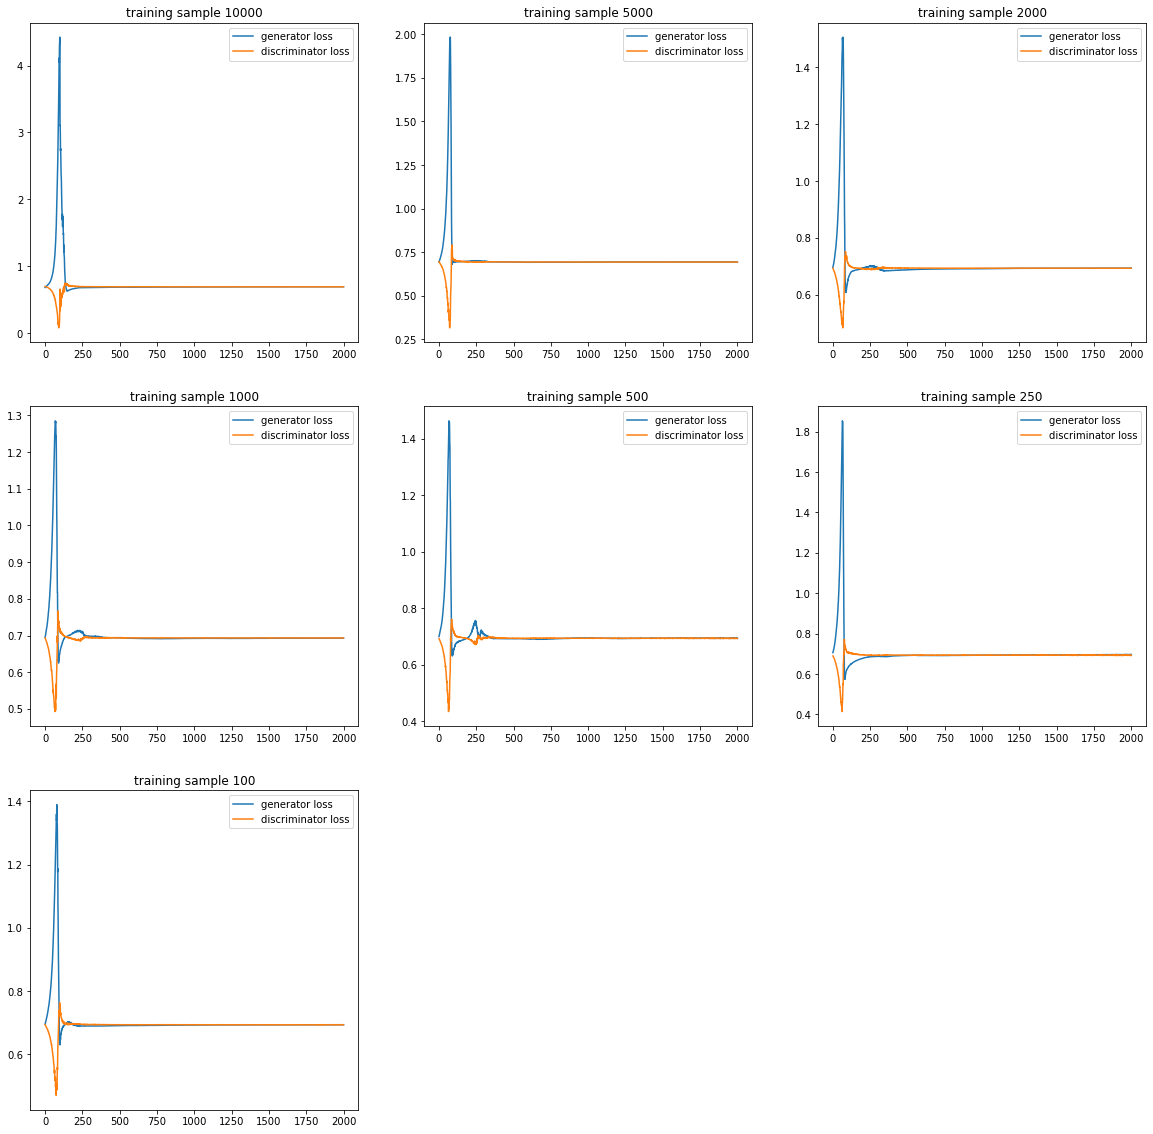

In [31]:
tr_samples=[10000, 5000, 2000, 1000, 500, 250, 100]
n_layers=328
rows=3
cols=3
pyplot.figure(figsize=(20,20))
for i in range(len(tr_samples)):
    pyplot.subplot(rows,cols,i+1)
    d_loss = np.loadtxt(f"data/dloss_1Dgamma_1_3_2_{tr_samples[i]}_{n_layers}_0.1", delimiter=' ')
    g_loss= np.loadtxt(f"data/gloss_1Dgamma_1_3_2_{tr_samples[i]}_{n_layers}_0.1", delimiter=' ')
    #pyplot.figure(figsize=(20, 7), dpi=80)
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f"training sample {tr_samples[i]}")
    pyplot.legend()

pyplot.show()


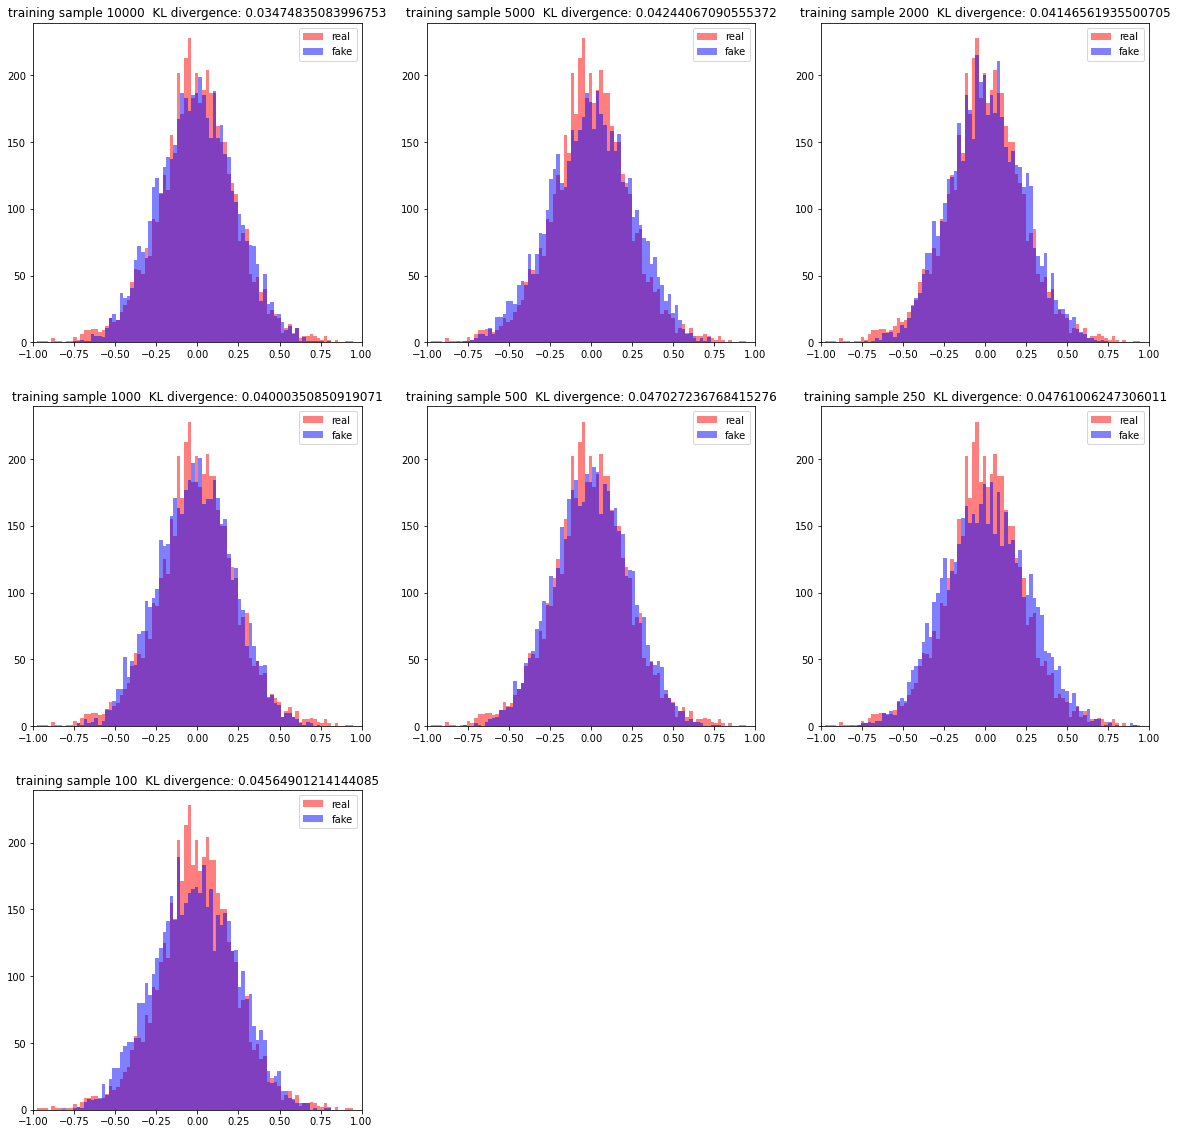

In [33]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems



# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=2
nbins=100
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

x_real=qc.generate_training_real_samples(samples)
pyplot.figure(figsize=(20,20))
distributions=[]
distributions.append(x_real)
for i in range(len(tr_samples)):
   
    #histogram distribution
    
    pyplot.subplot(rows,cols,i+1)
    params = np.loadtxt(f"data/PARAMS_1Dgamma_1_3_2_{tr_samples[i]}_{n_layers}_0.1", delimiter=' ', unpack='true')
    
    params = tf.Variable(params)
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
    
    distributions.append(x_fake)
    
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
    
    pyplot.xlim(-1,1)
    pyplot.title(f"training sample {tr_samples[i]}  KL divergence: {kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1) }")
    
    pyplot.legend()
    

In [34]:
from IPython.display import display
moments = pd.DataFrame(
    {
        "distribution":["real","fake 100000", "fake 5000", "fake 2000", "fake 1000", "fake 500", "fake 250", "fake 100" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment ":[stats.moment(i,moment=4)[0] for i in distributions]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real,-0.003863,0.057444,0.000009,0.013306
1,fake 100000,-0.004075,0.053458,0.000259,0.008071
2,fake 5000,-0.001465,0.061677,-0.001200,0.010445
3,fake 2000,0.007455,0.051083,0.000498,0.007343
4,fake 1000,-0.011369,0.051653,-0.000136,0.007470
5,fake 500,0.002609,0.051758,-0.000011,0.007474
6,fake 250,0.004762,0.063756,0.000777,0.011233
7,fake 100,-0.014275,0.061497,-0.000415,0.010198
